<a href="https://colab.research.google.com/github/tayyab5838/langgraph_projects/blob/main/projects/essay_grading_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Essay Grading System using LangGraph
### Overview
This notebook presents an automated essay grading system implemented using LangGraph and an LLM model. The system evaluates essays based on four key criteria: relevance, grammar, structure, and depth of analysis.

### Motivation
Automated essay grading systems can significantly streamline the assessment process in educational settings, providing consistent and objective evaluations. This implementation aims to demonstrate how large language models and graph-based workflows can be combined to create a sophisticated grading system.

### Key Components
1. State Graph: Defines the workflow of the grading process
2. LLM Model: Provides the underlying language understanding and analysis
3. Grading Functions: Separate functions for each evaluation criterion
4. Conditional Logic: Determines the flow of the grading process based on interim scores

### Method
The system follows a step-by-step approach to grade essays:

1. Content Relevance: Assesses how well the essay addresses the given topic
2. Grammar Check: Evaluates the essay's language usage and grammatical correctness
3. Structure Analysis: Examines the organization and flow of ideas in the essay
4.Depth of Analysis: Gauges the level of critical thinking and insight presented
Each step is conditionally executed based on the scores from previous steps, allowing for early termination of low-quality essays. The final score is a weighted average of all individual component scores.

### Conclusion
This notebook demonstrates a flexible and extensible approach to automated essay grading. By leveraging the power of large language models and a graph-based workflow, it offers a nuanced evaluation of essays that considers multiple aspects of writing quality. This system could be further refined and adapted for various educational contexts, potentially improving the efficiency and consistency of essay assessments.

In [56]:
%%capture --no-stderr
%pip install --q -U langgraph langchain_core langchain_google_genai

In [57]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import display, Image
import re

In [58]:
from google.colab import userdata

GEMINI_API_KEY = userdata.get('GEMNI_API_KEY')

### State Defination

In [59]:
from typing_extensions import TypedDict

class State(TypedDict):
    essay: str
    relevance_score: float
    grammar_score: float
    structure_score: float
    depth_score: float
    final_score: float


### Language Model Initialization

In [60]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=GEMINI_API_KEY)

### Grading Functions

In [61]:
def extractd_score(content: str)->float:
  """ Extract the numeric score from the llm response. """
  match = re.search(r'(\d+\.\d+)', content)
  if match:
    return float(match.group(1))
  raise ValueError(f"Could not extract score from: {content}")

def check_relevance(state: State)->State:
  """ Check the relevance of the essay to the given topic. """
  prompt = ChatPromptTemplate.from_template(
      "Analyze the relevance of the following essay to the given topic. "
      "Provide a relevance score between 0 and 1. "
      "Your response should start with 'Score: ' followed by the numeric score, "
      "then provide your explanation.\n\nEssay: {essay}"
  )
  result = llm.invoke(prompt.format(essay= state["essay"]))
  try:
    state["relevance_score"] = extractd_score(result.content)
  except ValueError as e:
    print(f"Error in check_relevance: {e}")
    state["relevance_score"] = 0.0
  return state

def check_grammar(state: State)->State:
  """ Check the grammar of the essay. """
  prompt = ChatPromptTemplate.from_template(
      "Analyze the grammar and language usage in the following essay. "
      "Provide a grammar score between 0 and 1. "
      "Your response should start with 'Score: ' followed by the numeric score, "
      "then provide your explanation.\n\nEssay: {essay}"
  )
  result = llm.invoke(prompt.format(essay= state["essay"]))
  try:
    state["grammar_score"] = extractd_score(result.content)
  except ValueError as e:
    print(f"Error in check_grammar: {e}")
    state["grammar_score"] = 0.0
  return state

def analyze_structure(state: State)->State:
  """ Analyze the structure of the essay. """
  prompt = ChatPromptTemplate.from_template(
     "Analyze the structure of the following essay. "
     "Provide a structure score between 0 and 1. "
     "Your response should start with 'Score: ' followed by the numeric score, "
    "then provide your explanation.\n\nEssay: {essay}"
  )
  result = llm.invoke(prompt.format(essay= state["essay"]))
  try:
    state["structure_score"] = extractd_score(result.content)
  except ValueError as e:
    print(f"Error in analyze_structure: {e}")
    state["structure_score"] = 0.0
  return state

def evaluate_depth(state: State)->State:
  """ Evaluate the depth of the essay. """
  prompt = ChatPromptTemplate.from_template(
  "Evaluate the depth of analysis in the following essay. "
  "Provide a depth score between 0 and 1. "
  "Your response should start with 'Score: ' followed by the numeric score, "
  "then provide your explanation.\n\nEssay: {essay}"
  )
  result = llm.invoke(prompt.format(essay= state["essay"]))
  try:
    state["depth_score"] = extractd_score(result.content)
  except ValueError as e:
    print(f"Error in evaluate_depth: {e}")
    state["depth_score"] = 0.0
  return state

def calculate_final_score(state: State)->State:
  """ Calculate the final score based on individual component scores. """
  state["final_score"] = (
      state["relevance_score"] * 0.3 +
      state["grammar_score"] * 0.2 +
      state["structure_score"] * 0.2 +
      state["depth_score"] * 0.3
  )
  return state

### workflow defination

In [62]:
# Initialize the state graph
build = StateGraph(State)

build.add_node("check_relevance", check_relevance)
build.add_node("check_grammar", check_grammar)
build.add_node("analyze_structure", analyze_structure)
build.add_node("evaluate_depth", evaluate_depth)
build.add_node("calculate_final_score", calculate_final_score)

build.add_edge(START, "check_relevance")

build.add_conditional_edges(
    "check_relevance",
    lambda x: "check_grammar" if x["relevance_score"] > 0.5 else "calculate_final_score",
)
build.add_conditional_edges(
    "check_grammar",
    lambda x: "analyze_structure" if x["grammar_score"] > 0.5 else "calculate_final_score",
)
build.add_conditional_edges(
    "analyze_structure",
    lambda x: "evaluate_depth" if x["structure_score"] > 0.5 else "calculate_final_score",
)
build.add_conditional_edges(
    "evaluate_depth",
    lambda x: "calculate_final_score"
)

build.add_edge("calculate_final_score", END)

graph = build.compile()

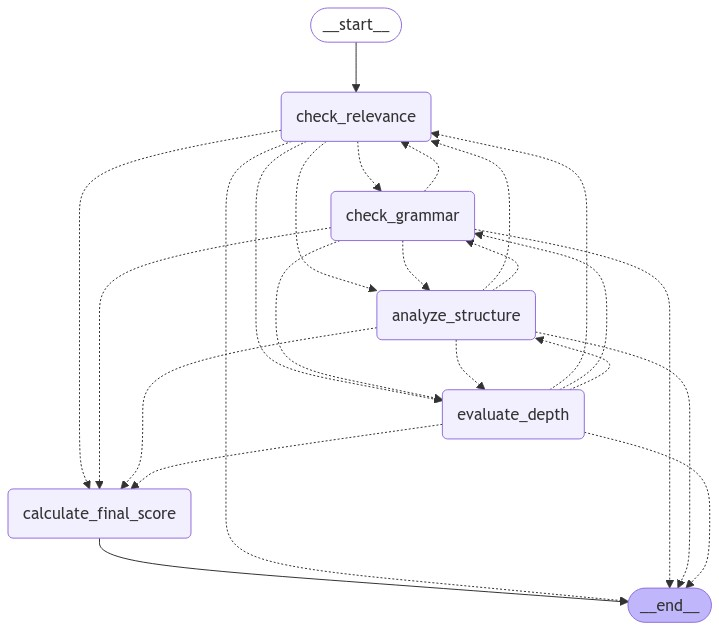

In [63]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [64]:
def essay_grade(essay: str)-> dict:
  """ Grade the essay based on the defined workflow. """
  initial_state = State(
      essay=essay,
      relevance_score=0.0,
      grammar_score=0.0,
      structure_score=0.0,
      depth_score=0.0,
      final_score=0.0,
  )
  result = graph.invoke(initial_state)
  return result

In [65]:
sample_essay = """
    The Impact of Artificial Intelligence on Modern Society

    Artificial Intelligence (AI) has become an integral part of our daily lives,
    revolutionizing various sectors including healthcare, finance, and transportation.
    This essay explores the profound effects of AI on modern society, discussing both
    its benefits and potential challenges.

    One of the most significant impacts of AI is in the healthcare industry.
    AI-powered diagnostic tools can analyze medical images with high accuracy,
    often surpassing human capabilities. This leads to earlier detection of diseases
    and more effective treatment plans. Moreover, AI algorithms can process vast
    amounts of medical data to identify patterns and insights that might escape
    human observation, potentially leading to breakthroughs in drug discovery and
    personalized medicine.

    In the financial sector, AI has transformed the way transactions are processed
    and monitored. Machine learning algorithms can detect fraudulent activities in
    real-time, enhancing security for consumers and institutions alike. Robo-advisors
    use AI to provide personalized investment advice, democratizing access to
    financial planning services.

    The transportation industry is another area where AI is making significant strides.
    Self-driving cars, powered by complex AI systems, promise to reduce accidents
    caused by human error and provide mobility solutions for those unable to drive.
    In logistics, AI optimizes routing and inventory management, leading to more
    efficient supply chains and reduced environmental impact.

    However, the rapid advancement of AI also presents challenges. There are concerns
    about job displacement as AI systems become capable of performing tasks
    traditionally done by humans. This raises questions about the need for retraining
    and reskilling the workforce to adapt to an AI-driven economy.

    Privacy and ethical concerns also arise with the increasing use of AI. The vast
    amount of data required to train AI systems raises questions about data privacy
    and consent. Additionally, there are ongoing debates about the potential biases
    in AI algorithms and the need for transparent and accountable AI systems.

    In conclusion, while AI offers tremendous benefits and has the potential to solve
    some of humanity's most pressing challenges, it also requires careful consideration
    of its societal implications. As we continue to integrate AI into various aspects
    of our lives, it is crucial to strike a balance between technological advancement
    and ethical considerations, ensuring that the benefits of AI are distributed
    equitably across society.
    """


In [66]:
# Grade the sample essay
result = essay_grade(sample_essay)

# Display the results
print(f"Final Essay Score: {result['final_score']:.2f}\n")
print(f"Relevance Score: {result['relevance_score']:.2f}")
print(f"Grammar Score: {result['grammar_score']:.2f}")
print(f"Structure Score: {result['structure_score']:.2f}")
print(f"Depth Score: {result['depth_score']:.2f}")

Final Essay Score: 0.81

Relevance Score: 1.00
Grammar Score: 0.95
Structure Score: 0.70
Depth Score: 0.60
